# Notatnik prezentujący porównanie jakości dostępnych rozwiązań OCR.

## Autorzy: Tomasz Gruzdzis 171898, Krzysztof Wicki 171703

Zdjęcia pochodzą z pozyskanego samodzielnie zbioru danych, poddanego pod działanie modelu yolov5 w celu wyodrębnienia tablic rejestracyjnych.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
LP_PATH = "drive/MyDrive/yolo/license-plate/"

In [23]:
import numpy as np
import cv2

Przyjmujemy że przy każdym OCR sprawdzamy 2 rodzaje obrazów wejściowych, pobrane cropy uzyskane poprzez yolo i te same obrazy ale poddane automatycznej rotacji. Z każdej puli uzyskanych wynikó będziemy liczyć poprawnie odczytane numery, gdzie dajemy tolerancje 3 znaków do uznania punktu za poprawnie odczytany numer tablicy, nadmierowe informacje nie są brane pod uwagę.

In [17]:
from scipy.ndimage import interpolation as inter

class OCRPreprocessor:

    def __init__(self):
        self.rotation_delta = 1
        self.rotation_limit = 10

    def automatic_brightness_and_contrast(self, image, clip_hist_percent=10):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_size = len(hist)

        accumulator = []
        accumulator.append(float(hist[0]))
        for index in range(1, hist_size):
            accumulator.append(accumulator[index - 1] + float(hist[index]))

        maximum = accumulator[-1]
        clip_hist_percent *= (maximum / 100.0)
        clip_hist_percent /= 2.0

        minimum_gray = 0
        while accumulator[minimum_gray] < clip_hist_percent:
            minimum_gray += 1

        maximum_gray = hist_size - 1
        while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
            maximum_gray -= 1

        alpha = 255 / (maximum_gray - minimum_gray)
        beta = -minimum_gray * alpha

        auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return auto_result, alpha, beta

    def get_binary_image(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        binary_image = cv2.adaptiveThreshold(
            gray,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            11,
            2
        )
        return binary_image

    def get_denoised_image(self, image):
        return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 15)

    def to_rgb(self, image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    def find_score_for_rotation(self, arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score

    def rotate_img(self, image):
        binary_image = self.get_binary_image(image)
        delta = self.rotation_delta
        limit = self.rotation_limit
        angles = np.arange(-limit, limit + delta, delta)
        scores = []

        for angle in angles:
            hist, score = self.find_score_for_rotation(binary_image, angle)
            scores.append(score)
            best_score = max(scores)

        best_angle = angles[scores.index(best_score)]
        print('Best angle: {}'.format(best_angle))  # correct skew
        image = inter.rotate(image, best_angle, reshape=False, order=0)

        return image

preprocessor = OCRPreprocessor()

Wybrane numery rejestracyjne, 18 obrazów.

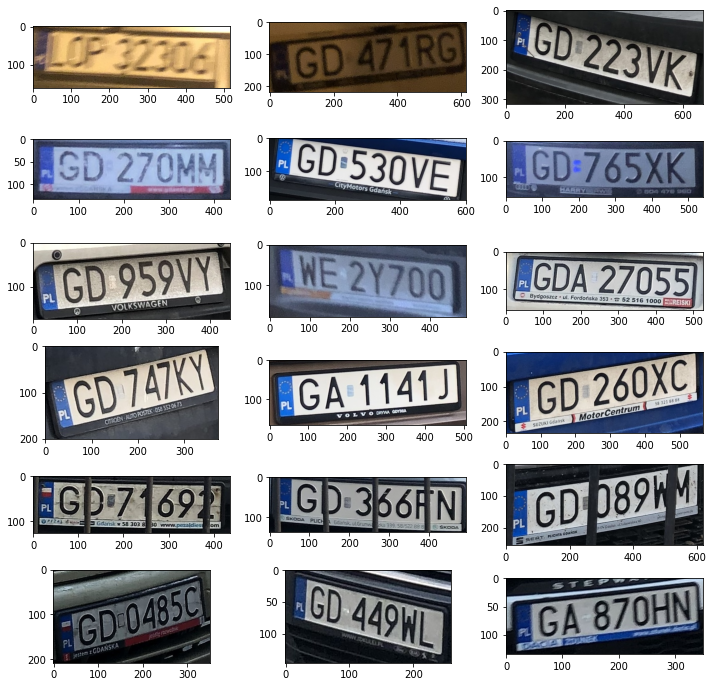

In [21]:
import glob

image_list = []
for filename in glob.glob(LP_PATH+'*.jpg'):
    im = cv2.imread(filename)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    image_list.append(im)

import matplotlib.pyplot as plt 
n_row = 6
n_col = 3
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(image_list, axs):
    ax.imshow(img)
plt.show()

I obrazy poddane automatycznej rotacji

Best angle: 3
Best angle: -1
Best angle: -1
Best angle: 0
Best angle: 8
Best angle: 2
Best angle: -5
Best angle: 6
Best angle: 2
Best angle: -1
Best angle: -4
Best angle: -10
Best angle: 1
Best angle: 3
Best angle: -9
Best angle: -10
Best angle: 10
Best angle: -6


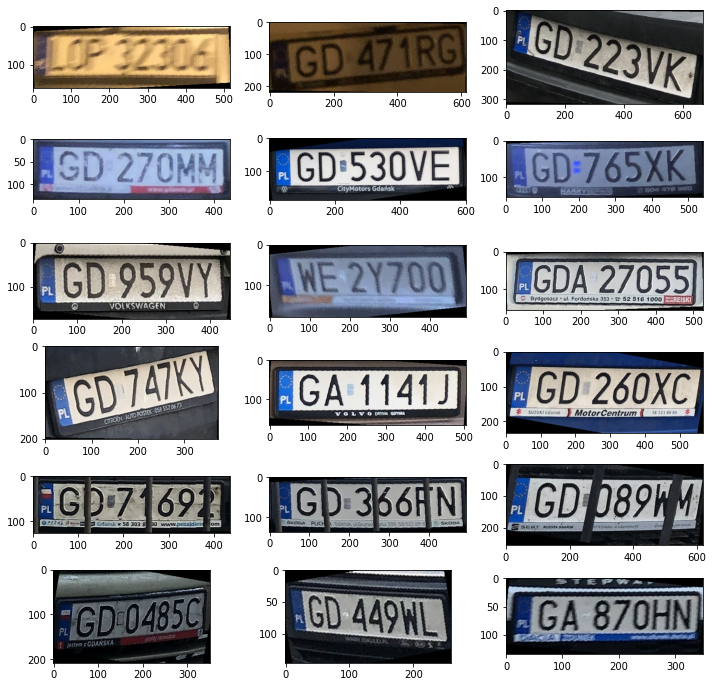

In [24]:
rotated_images = []

for im in image_list:
  rotated = preprocessor.rotate_img(im)
  rotated_images.append(rotated)

n_row = 6
n_col = 3
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(rotated_images, axs):
    ax.imshow(img)
plt.show()

## Tesseract-OCR

In [5]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (27.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [6]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14070 sha256=b594f8adeb41efd2327acf6b758faed92f25f80cae04c43a5bf3059b4374b64d
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [7]:
import pytesseract
import shutil
import os
import random

In [9]:
	def build_tesseract_options(psm=7):
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		options += " --psm {}".format(psm)
		return options

In [10]:
pytesseract_results = []
for im in image_list:
  extractedInformation = pytesseract.image_to_string(im, config=build_tesseract_options(9))
  pytesseract_results.append(extractedInformation)

pytesseract_results

['BF 27306)\n\x0c',
 'ICD AZ IRS)\n\x0c',
 '2230\n\x0c',
 'SD 270MM]\n\x0c',
 'fee SUV E\n\x0c',
 'BGD:765XK]\n\x0c',
 'CO TINY\n\x0c',
 'NE 2Y700\n\x0c',
 'BGDA 27055\n\x0c',
 'roy ae\n\x0c',
 'GA 1141)\n\x0c',
 'ACD 260XC\n\x0c',
 'AGD*7 1692\n\x0c',
 'GD: 366HN\n\x0c',
 'rcDpe7i\n\x0c',
 'roi\n\x0c',
 'Ty\n\x0c',
 'BGA 870HN)\n\x0c']

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


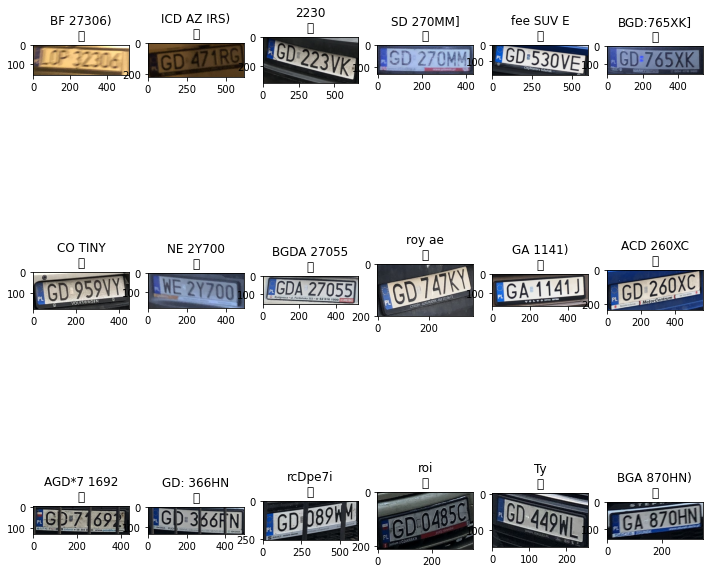

In [14]:
n_row = 3
n_col = 6
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
index = 0
for img, ax in zip(image_list, axs):
    ax.imshow(img)
    ax.set_title(pytesseract_results[index]) 
    index += 1
plt.show()

Uzyskano 9/18 pkt

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


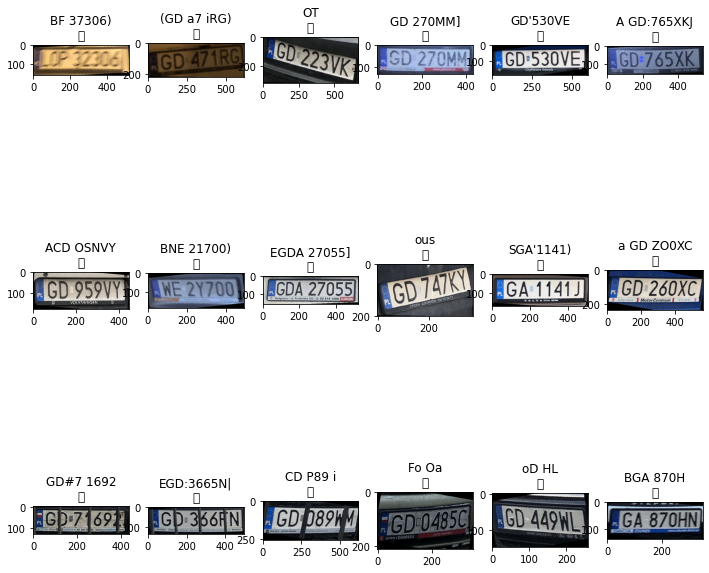

In [30]:
pytesseract_results_rotaed = []
for im in rotated_images:
  extractedInformation = pytesseract.image_to_string(im, config=build_tesseract_options(9))
  pytesseract_results_rotaed.append(extractedInformation)

n_row = 3
n_col = 6
_, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
axs = axs.flatten()
index = 0
for img, ax in zip(rotated_images, axs):
    ax.imshow(img)
    ax.set_title(pytesseract_results_rotaed[index]) 
    index += 1
plt.show()

Uzyskano 7/18, wynik po rotacji pogorszony.

## EASY OCR

In [27]:
!pip install easyocr
!pip install imutils

     |████████████████████████████████| 63.6 MB 1.3 MB/s 


In [28]:
import imutils
import easyocr

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


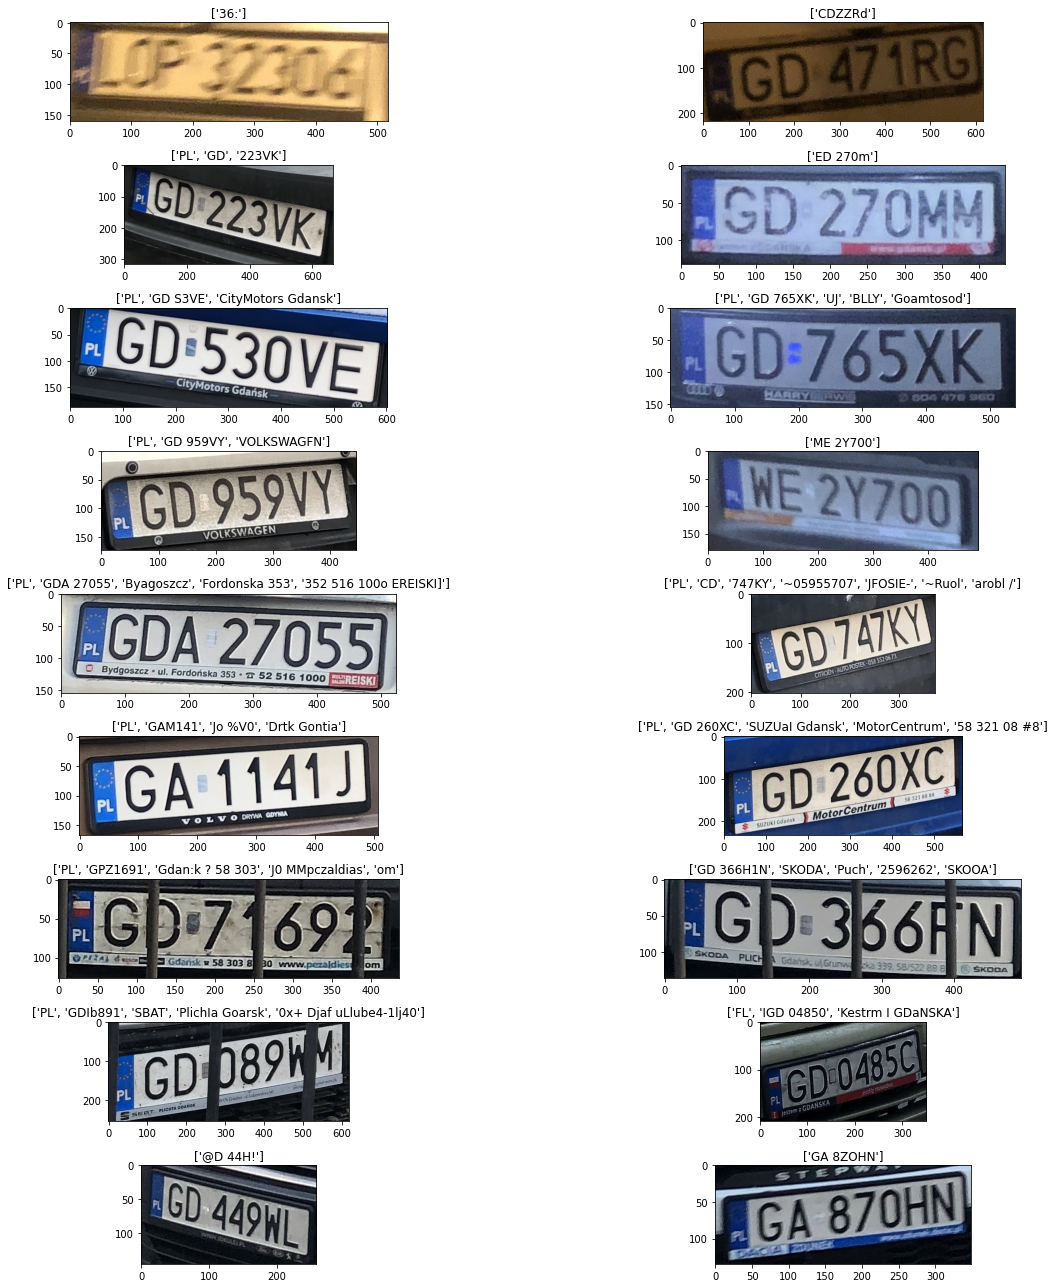

In [54]:
easyocr_results = []
easyocr_reader = easyocr.Reader(['en'])

for im in rotated_images:
  extractedInformation = easyocr_reader.readtext(im, detail=0)
  easyocr_results.append(extractedInformation)

n_row = 9
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(18, 18))
axs = axs.flatten()
index = 0
for img, ax in zip(image_list, axs):
    ax.imshow(img)
    ax.set_title(easyocr_results[index]) 
    index += 1
plt.tight_layout()
plt.show()

Uzyskano 12/18, więcej niż Tesseract

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


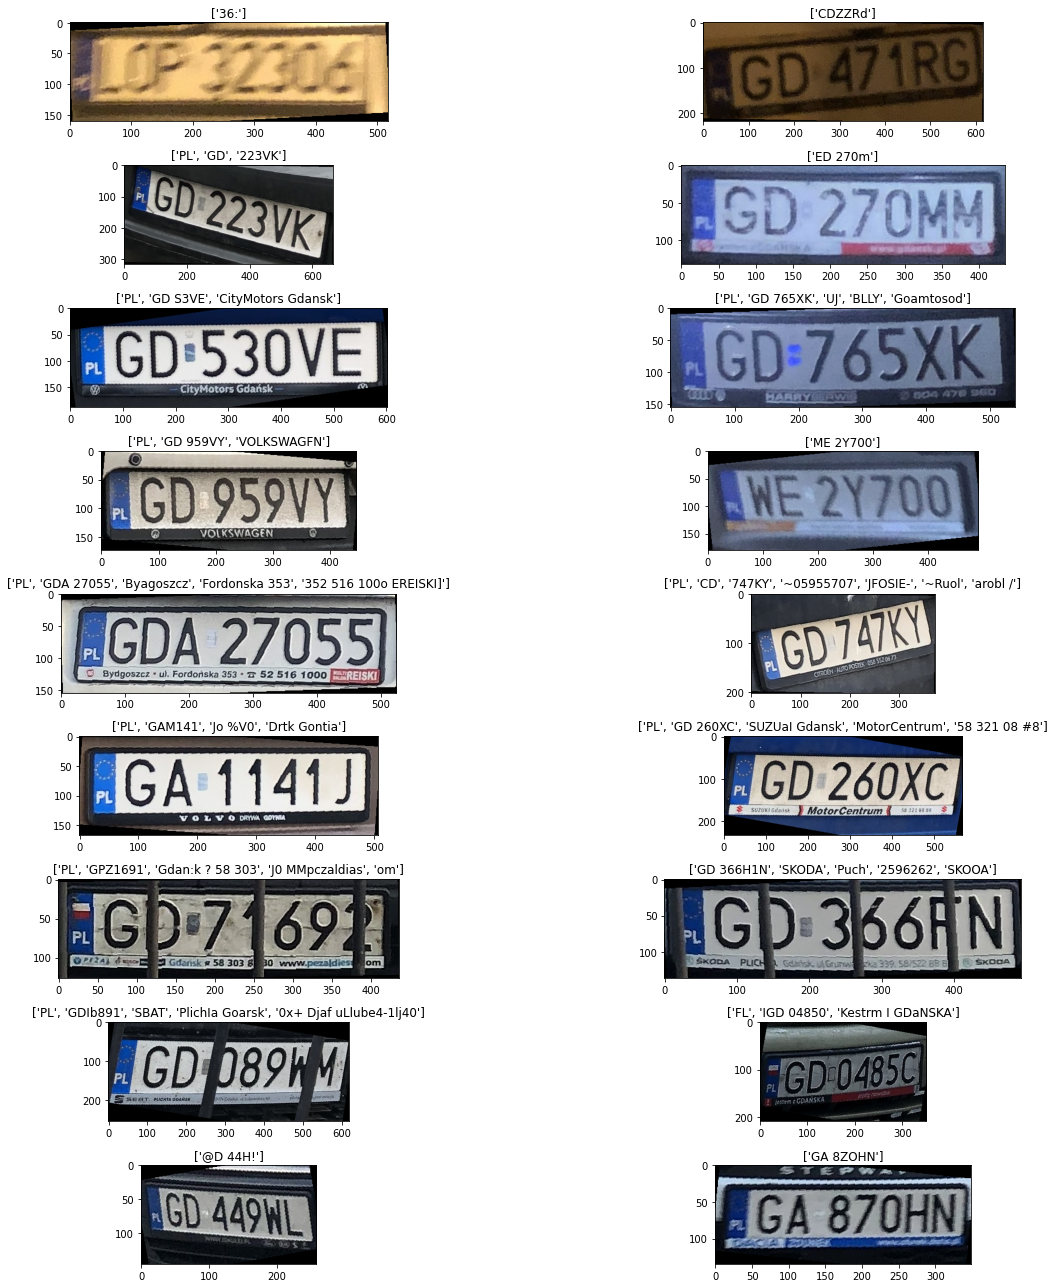

In [52]:
easyocr_results_rotated = []
easyocr_reader = easyocr.Reader(['en'])

for im in rotated_images:
  extractedInformation = easyocr_reader.readtext(im, detail=0)
  easyocr_results_rotated.append(extractedInformation)

n_row = 9
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(18, 18))
axs = axs.flatten()
index = 0
for img, ax in zip(rotated_images, axs):
    ax.imshow(img)
    ax.set_title(easyocr_results_rotated[index]) 
    index += 1
plt.tight_layout()
plt.show()

Uzyskano 13/18

## Keras OCR

In [35]:
pip install git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-47by4bg_/keras-ocr_c9a79f98395542599c623c412d3b959c
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-47by4bg_/keras-ocr_c9a79f98395542599c623c412d3b959c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 890 kB 13.6 MB/s 
     |████████████████████████████████| 603 kB 63.5 MB/s 
     |████████████████████████████████| 9.5 MB 34.2 MB/s 
     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.9-py3-none-any.whl size=41435 sha256=d8f1b253e2e5d644c48363bae229194f0c05848d9017844b6de50a75b21546c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-pz7o8gqk/wheels/20/d0/06/ed290995144ec8dde71d3a91d0d590145445c01be60ea70c9b
Successfully built keras-ocr


In [36]:
import keras_ocr

In [37]:
!pip uninstall opencv-python
!pip install -U opencv-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libavcodec-4cf96bc1.so.58.65.103
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libavformat-b798543f.so.58.35.101
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libavutil-ac3ec209.so.56.38.100
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libcrypto-cc2fb98b.so.1.1
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libswresample-994f1795.so.3.6.100
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libswscale-99a5f1f1.so.5.6.100
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libvpx-3dd7ccd6.so.6.2.0
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 60.4 MB 1.1 MB/s 
ERROR: pip'

In [38]:
import cv2

In [39]:
kerasocr_reader = keras_ocr.pipeline.Pipeline()
kerasocr_results = kerasocr_reader.recognize(image_list)

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [48]:
kerasocr_results

[[], [('azirg', array([[271.90887 ,  28.479893],
          [600.55664 ,  12.316895],
          [606.966   , 142.641   ],
          [278.31824 , 158.804   ]], dtype=float32)),
  ('gd', array([[ 70.,  61.],
          [236.,  61.],
          [236., 177.],
          [ 70., 177.]], dtype=float32))], [('gdzxvk',
   array([[109.60846 ,  38.792725],
          [620.3948  , 140.44174 ],
          [595.66675 , 264.69986 ],
          [ 84.880424, 163.05084 ]], dtype=float32)),
  ('pi', array([[ 38.,  93.],
          [ 67.,  93.],
          [ 67., 119.],
          [ 38., 119.]], dtype=float32))], [('zzomm',
   array([[183.1839  ,  26.631279],
          [412.4134  ,  29.206886],
          [411.59137 , 102.36619 ],
          [182.36188 ,  99.79058 ]], dtype=float32)),
  ('gd', array([[ 53.,  29.],
          [161.,  29.],
          [161.,  96.],
          [ 53.,  96.]], dtype=float32))], [('gdiszove',
   array([[ 95.308716,   8.331619],
          [565.0913  ,  65.44246 ],
          [552.8235  , 166.35

In [45]:
kerasocr_results_cropped = []

for r in kerasocr_results:
  temp = []
  for sr in r:
    temp.append(sr[0])
  kerasocr_results_cropped.append(temp)

In [47]:
kerasocr_results_cropped

[[],
 ['azirg', 'gd'],
 ['gdzxvk', 'pi'],
 ['zzomm', 'gd'],
 ['gdiszove', 'pl', 'citymotors', 'gdansk'],
 ['gd765xk', 'pl', 'o', 'ty', 'con', 'aze', 'ss'],
 ['9s0vy', 'gd', 'pl', 'volkswagen'],
 ['we', '2y700'],
 ['gda',
  '27055',
  'pl',
  'bydgoszcz',
  'ul',
  'fordonska',
  '353',
  'd',
  '52',
  '516',
  '1000',
  'reiski'],
 ['azky', 'gd', 'sxose', 'oss', 'postes', 'pl', 'pno', 'ciroen'],
 ['j', 'ga1141', 'pl', 'gonna', 'drmna', 'o', 'v', 'vol'],
 ['200xc',
  'gd',
  'ss',
  's8',
  '21',
  '5s',
  'motorcentrum',
  'pl',
  'gdansk',
  'suzuki'],
 ['g',
  'dv',
  '60',
  'pl',
  'drie',
  'scie',
  'cdansk',
  '58',
  '703',
  'b',
  '8',
  '50',
  'womwlpezaldies',
  'om'],
 ['g',
  '366h',
  'in',
  'pl',
  'skoed',
  'plich',
  'cderse',
  'ugu',
  '89',
  'ra',
  'sense',
  'be',
  'g',
  'skoca'],
 ['089h',
  'gd',
  'alpl',
  'ol',
  'lo',
  'pl',
  'ubonale',
  'ue',
  'gaaat',
  'olt',
  'odanisk',
  'plichta',
  'sea'],
 ['gd0485c', 'pl', 'zgdanska', 'iestem'],
 ['gd',

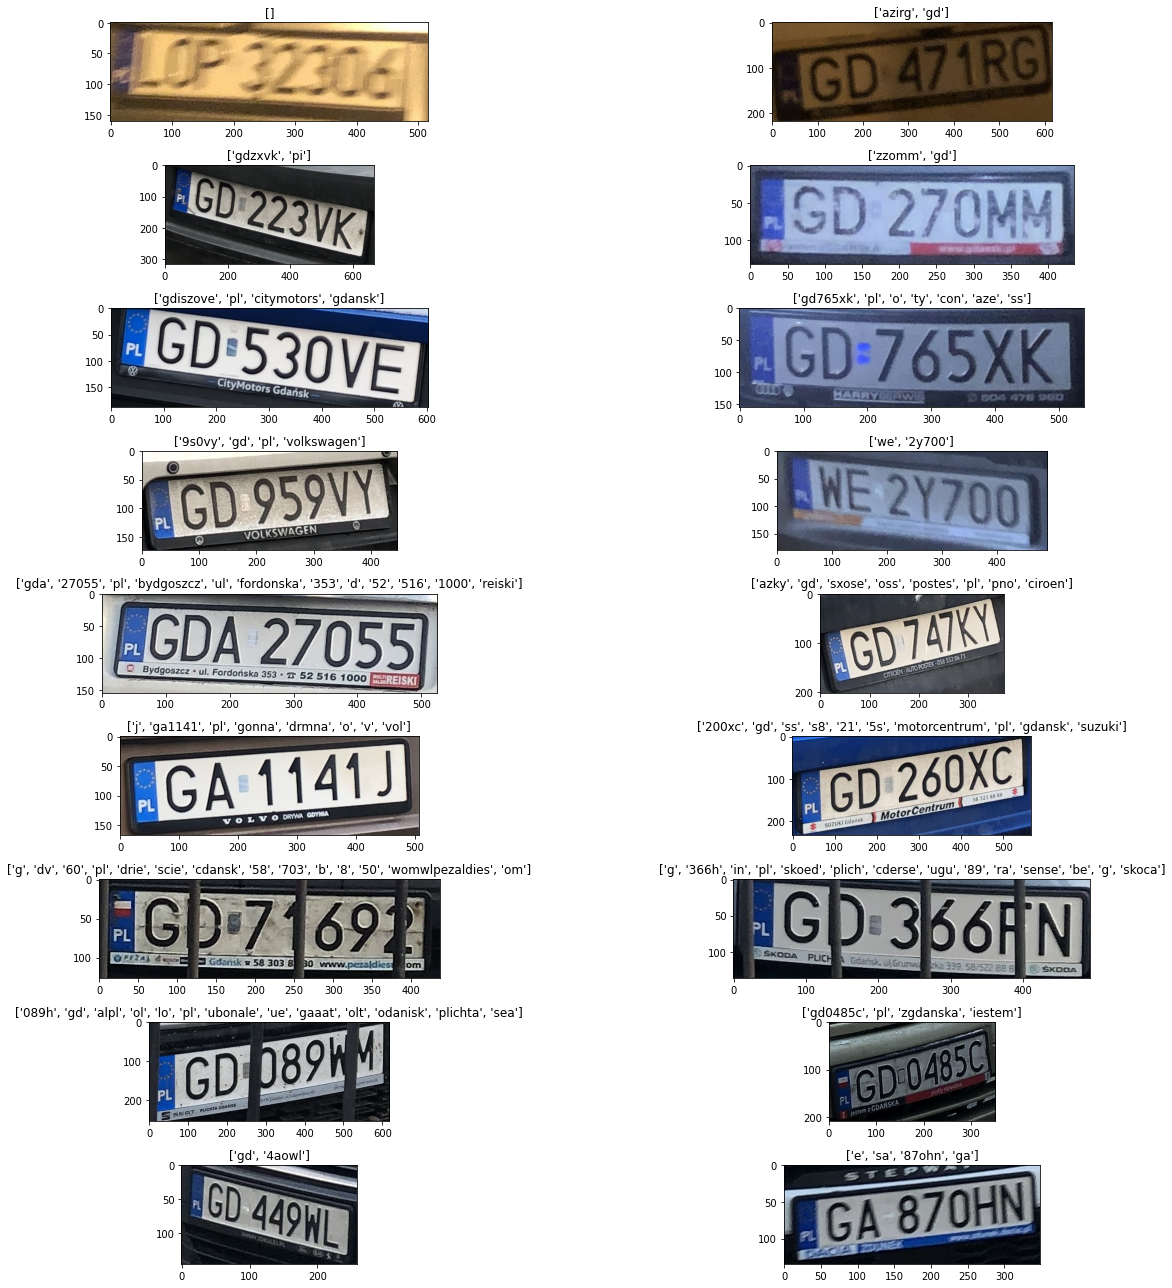

In [55]:
n_row = 9
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(18, 18))
axs = axs.flatten()
index = 0
for img, ax in zip(image_list, axs):
    ax.imshow(img)
    ax.set_title(kerasocr_results_cropped[index]) 
    index += 1
plt.tight_layout()
plt.show()

7/18

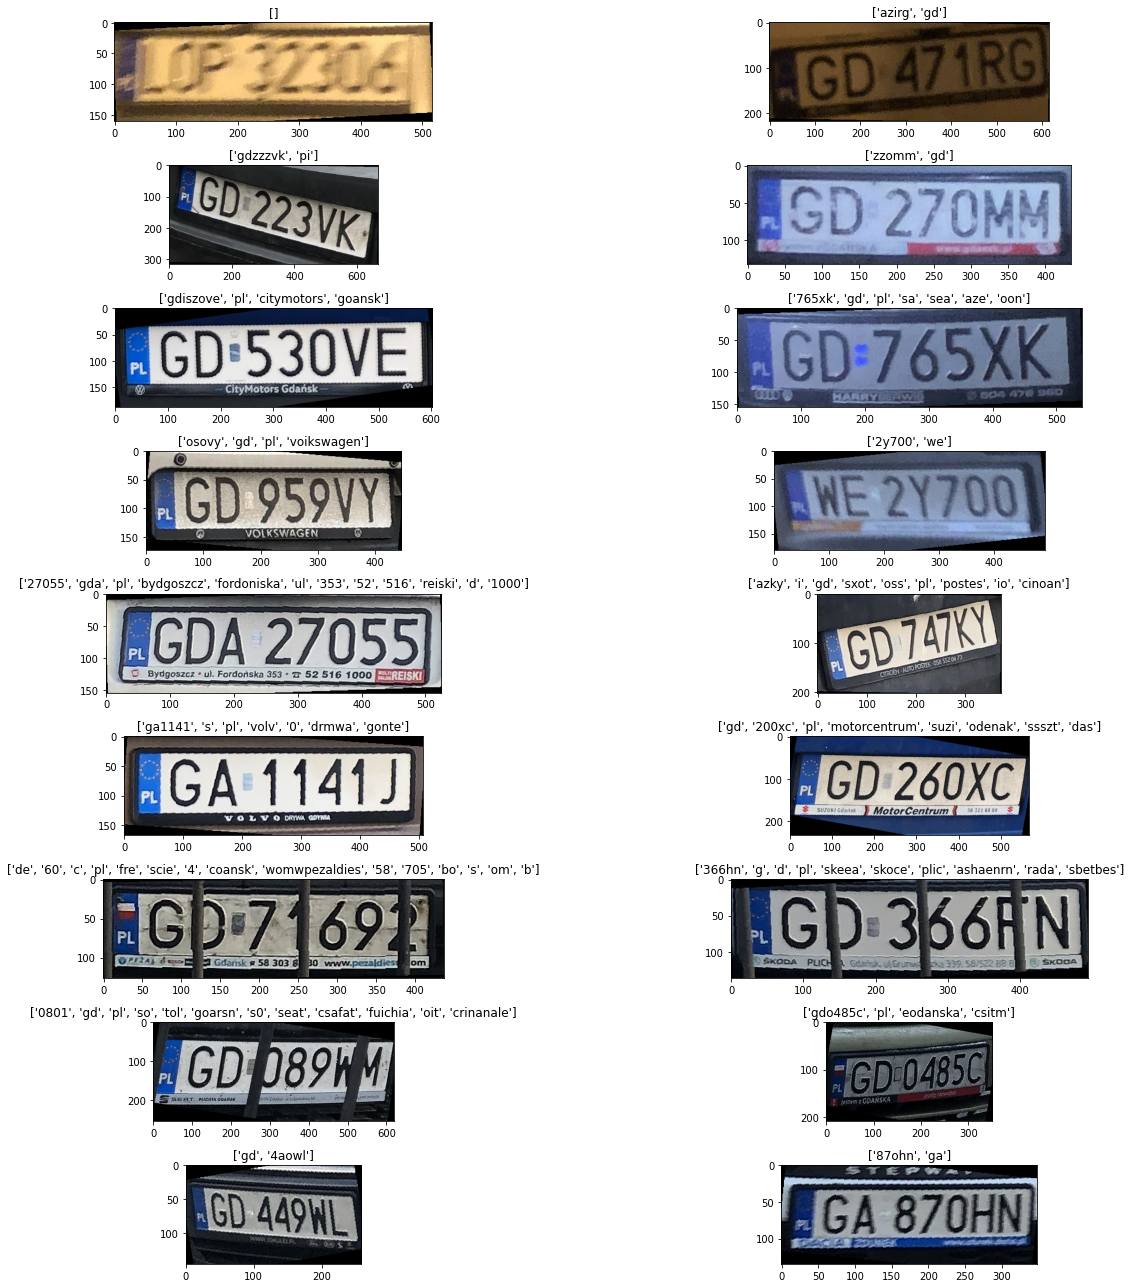

In [56]:
kerasocr_results_rotated = kerasocr_reader.recognize(rotated_images)
kerasocr_results_cropped_rotated = []

for r in kerasocr_results_rotated:
  temp = []
  for sr in r:
    temp.append(sr[0])
  kerasocr_results_cropped_rotated.append(temp)

n_row = 9
n_col = 2
_, axs = plt.subplots(n_row, n_col, figsize=(18, 18))
axs = axs.flatten()
index = 0
for img, ax in zip(rotated_images, axs):
    ax.imshow(img)
    ax.set_title(kerasocr_results_cropped_rotated[index]) 
    index += 1
plt.tight_layout()
plt.show()

9/18

Najlepiej w porównaniu wypadł Easy OCR, kóry okazął się również najbardziej uniwersalnym, można jednak zauważyć że Tesseract radził sobie lepiej w trudniejszym przypadku, w któym EASY OCR nie przygotował stosownej predykcji.